# Installation

In [1]:
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.7 MB/s eta 0:00:00


# Vérification avant de commencer

In [2]:
import ultralytics

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
ultralytics.checks()

Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.5/112.6 GB disk)


Visualisation des ressources et utilisation GPU

In [4]:
!nvidia-smi

Tue May 20 11:04:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Vérification disponibilité GPU

In [5]:
import torch
print("GPU disponible :", torch.cuda.is_available())

GPU disponible : True


# Préparation du dataset

In [6]:
!unzip -q /content/data.zip -d /content/custom_data_raw

## Organisation à avoir

```
custom_data/
├── images/
│   ├── train/
│   └── val/
├── labels/
│   ├── train/
│   └── val/


## Réorganisation du dataset

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Répertoire d'origine pour les images et annotations
raw_data_path_images = "/content/custom_data_raw/images"  # Images sont dans ce dossier
raw_data_path_labels = "/content/custom_data_raw/obj_train_data"  # Annotations dans ce dossier

# Obtenir toutes les images (jpg/png) présentes dans le dossier "images"
images = [f for f in os.listdir(raw_data_path_images) if f.endswith(('.jpg', '.png'))]

# Split train/val (80% train, 20% val)
train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

# Création des dossiers cible pour images et labels
base_path = "/content/custom_data"


os.makedirs(base_path + "/images/train", exist_ok=True)
os.makedirs(base_path + "/images/val", exist_ok=True)
os.makedirs(base_path + "/labels/train", exist_ok=True)
os.makedirs(base_path + "/labels/val", exist_ok=True)

def move_data(image_list, split):
    for img_name in image_list:
        # Déplacer l'image vers le bon dossier
        src_img = os.path.join(raw_data_path_images, img_name)
        dst_img = os.path.join(base_path, f"images/{split}", img_name)
        shutil.copy(src_img, dst_img)

        # Vérifier et déplacer l'annotation .txt correspondante
        txt_name = img_name.rsplit('.', 1)[0] + '.txt'
        txt_src = os.path.join(raw_data_path_labels, txt_name)
        txt_dst = os.path.join(base_path, f"labels/{split}", txt_name)

        if os.path.exists(txt_src):
            shutil.copy(txt_src, txt_dst)
        else:
            print(f"Pas d'annotation pour {img_name}")

# Appliquer le déplacement aux deux splits : train et val
move_data(train_imgs, "train")
move_data(val_imgs, "val")


# Augmentation


In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import cv2
import os

# === PARAMÈTRES ===
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=20, p=0.3),
    A.RandomGamma(p=0.3)
    # A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.4)
])

# Tu appliques l'augmentation uniquement sur le dossier d'entraînement
augmented_path = "/content/custom_data_augmented/images/train"
augmented_label_path = "/content/custom_data_augmented/labels/train"
os.makedirs(augmented_path, exist_ok=True)
os.makedirs(augmented_label_path, exist_ok=True)

original_train_images_path = "/content/custom_data/images/train"
original_train_labels_path = "/content/custom_data/labels/train"

# Copie les fichiers originaux
for img_file in tqdm(os.listdir(original_train_images_path), desc="Copie des images originales"):
    if not img_file.endswith(('.jpg', '.png')):
        continue
    img_path = os.path.join(original_train_images_path, img_file)
    label_path = os.path.join(original_train_labels_path, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))

    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # Sauvegarde originale
    cv2.imwrite(os.path.join(augmented_path, img_file), img)
    shutil.copy(label_path, os.path.join(augmented_label_path, os.path.basename(label_path)))

    # Augmente 2 fois chaque image
    for i in range(2):
        augmented = augmentations(image=img)["image"]
        aug_img_name = img_file.replace('.', f'_aug{i}.')
        aug_lbl_name = img_file.replace('.jpg', f'_aug{i}.txt').replace('.png', f'_aug{i}.txt')

        cv2.imwrite(os.path.join(augmented_path, aug_img_name), augmented)
        shutil.copy(label_path, os.path.join(augmented_label_path, aug_lbl_name))

print("✅ Dataset augmenté.")


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
Copie des images originales: 100%|██████████| 36/36 [00:13<00:00,  2.61it/s]

✅ Dataset augmenté.


In [9]:
# Copie val original sans modification
original_val_images_path = "/content/custom_data/images/val"
original_val_labels_path = "/content/custom_data/labels/val"

val_img_out_dir = "/content/custom_data_augmented/images/val"
val_lbl_out_dir = "/content/custom_data_augmented/labels/val"

os.makedirs(val_img_out_dir, exist_ok=True)
os.makedirs(val_lbl_out_dir, exist_ok=True)

for img_file in os.listdir(original_val_images_path):
    if not img_file.endswith(('.jpg', '.png')):
        continue

    img_src = os.path.join(original_val_images_path, img_file)
    lbl_src = os.path.join(original_val_labels_path, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))

    img_dst = os.path.join(val_img_out_dir, img_file)
    lbl_dst = os.path.join(val_lbl_out_dir, os.path.basename(lbl_src))

    shutil.copy(img_src, img_dst)
    shutil.copy(lbl_src, lbl_dst)

print("✅ Validation copiée sans modification.")


✅ Validation copiée sans modification.


# Split des images du dataset

In [10]:
import os
import cv2
import shutil

# === PARAMÈTRES ===
# input_root = "/content/custom_data"
input_root = "/content/custom_data_augmented"

output_root = "/content/split_custom_data"

base_split_path = "/content/split_custom_data"

tile_size = 640
overlap = 0

splits = ["train", "val"]

def yolo_to_bbox(x_center, y_center, w, h, img_w, img_h):
    x1 = int((x_center - w / 2) * img_w)
    y1 = int((y_center - h / 2) * img_h)
    x2 = int((x_center + w / 2) * img_w)
    y2 = int((y_center + h / 2) * img_h)
    return x1, y1, x2, y2

def bbox_to_yolo(x1, y1, x2, y2, tile_w, tile_h):
    x_center = (x1 + x2) / 2 / tile_w
    y_center = (y1 + y2) / 2 / tile_h
    w = (x2 - x1) / tile_w
    h = (y2 - y1) / tile_h
    return x_center, y_center, w, h

# Boucle sur train et val
for split in splits:
    input_img_dir = os.path.join(input_root, f"images/{split}")
    input_lbl_dir = os.path.join(input_root, f"labels/{split}")
    output_img_dir = os.path.join(output_root, f"images/{split}")
    output_lbl_dir = os.path.join(output_root, f"labels/{split}")

    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_lbl_dir, exist_ok=True)

    for filename in os.listdir(input_img_dir):
        if not filename.lower().endswith(('.jpg', '.png')):
            continue

        basename = os.path.splitext(filename)[0]
        img_path = os.path.join(input_img_dir, filename)
        label_path = os.path.join(input_lbl_dir, f"{basename}.txt")

        img = cv2.imread(img_path)
        img_h, img_w = img.shape[:2]

        annotations = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) == 5:
                        cls, xc, yc, w, h = map(float, parts)
                        annotations.append((cls, *yolo_to_bbox(xc, yc, w, h, img_w, img_h)))

        step = tile_size - overlap
        tile_id = 0

        for y in range(0, img_h, step):
            for x in range(0, img_w, step):
                tile = img[y:y + tile_size, x:x + tile_size]
                tile_h, tile_w = tile.shape[:2]

                if tile_h < tile_size or tile_w < tile_size:
                    continue

                tile_filename = f"{basename}_{tile_id}.jpg"
                label_filename = f"{basename}_{tile_id}.txt"
                tile_id += 1

                cv2.imwrite(os.path.join(output_img_dir, tile_filename), tile)

                new_annots = []
                for cls, x1, y1, x2, y2 in annotations:
                    if x1 >= x + tile_size or x2 <= x or y1 >= y + tile_size or y2 <= y:
                        continue

                    bx1 = max(0, x1 - x)
                    by1 = max(0, y1 - y)
                    bx2 = min(tile_size, x2 - x)
                    by2 = min(tile_size, y2 - y)

                    if bx2 - bx1 < 5 or by2 - by1 < 5:
                        continue

                    x_c, y_c, w, h = bbox_to_yolo(bx1, by1, bx2, by2, tile_size, tile_size)
                    new_annots.append(f"{int(cls)} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}")

                with open(os.path.join(output_lbl_dir, label_filename), "w") as f:
                    f.write("\n".join(new_annots))

    print(f"✅ Split terminé pour '{split}' — {len(os.listdir(output_img_dir))} tuiles générées")


✅ Split terminé pour 'train' — 1992 tuiles générées
✅ Split terminé pour 'val' — 180 tuiles générées


# HSV

In [11]:
import os
import cv2
from tqdm import tqdm

input_root = "/content/split_custom_data/images"
output_root = "/content/split_custom_data_hsv/images"

splits = ["train", "val"]

for split in splits:
    in_dir = os.path.join(input_root, split)
    out_dir = os.path.join(output_root, split)
    os.makedirs(out_dir, exist_ok=True)

    for img_file in tqdm(os.listdir(in_dir), desc=f"Conversion HSV - {split}"):
        if not img_file.lower().endswith(('.jpg', '.png')):
            continue

        img_path = os.path.join(in_dir, img_file)
        img = cv2.imread(img_path)  # BGR
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        out_path = os.path.join(out_dir, img_file)
        cv2.imwrite(out_path, hsv)


Conversion HSV - val: 100%|██████████| 180/180 [00:01<00:00, 113.91it/s]


In [12]:
import shutil

label_input_root = "/content/split_custom_data/labels"
label_output_root = "/content/split_custom_data_hsv/labels"

splits = ["train", "val"]
for split in splits:
    in_dir = os.path.join(label_input_root, split)
    out_dir = os.path.join(label_output_root, split)
    os.makedirs(out_dir, exist_ok=True)

    for label_file in os.listdir(in_dir):
        if label_file.endswith(".txt"):
            shutil.copy(os.path.join(in_dir, label_file), os.path.join(out_dir, label_file))

print("✅ Labels copiés vers le dossier HSV.")


✅ Labels copiés vers le dossier HSV.


# Génération des YAML

Dynamique :

In [13]:
# Chemin vers le fichier obj.names exporté par CVAT (modifie si besoin)
obj_names_path = "/content/custom_data_raw/obj.names"

# Lire les noms de classes depuis obj.names
with open(obj_names_path, 'r') as f:
    class_names = [line.strip() for line in f if line.strip()]

# Générer le contenu du fichier YAML avec les augmentations de couleur
yaml_content = f"""
path: {base_split_path}
train: images/train
val: images/val
nc: {len(class_names)}
names: {class_names}
augment: True  # Activer l'augmentation des données
auto_augment: albumentations



# weights: [0.9, 0.1]  # Exemple de pondération si olive est trop présente
"""


# Écriture du fichier data.yaml
with open(f"{base_path}/data.yaml", "w") as f:
    f.write(yaml_content.strip())

with open(f"{base_split_path}/data.yaml", "w") as f:
    f.write(yaml_content.strip())

print(" Fichier data.yaml généré automatiquement :")
print(yaml_content)


 Fichier data.yaml généré automatiquement :

path: /content/split_custom_data
train: images/train
val: images/val
nc: 2
names: ['olive', 'potential_olive']
augment: True  # Activer l'augmentation des données
auto_augment: albumentations



# weights: [0.9, 0.1]  # Exemple de pondération si olive est trop présente



In [14]:
custom_train_cfg = """
# train_custom.yaml — Configuration d'entraînement pour YOLOv8

# Chemins
data: /content/split_custom_data/data.yaml
model: yolov8m.pt
# model: yolo11x.pt

# Entraînement
epochs: 30
batch: 16
imgsz: 320
device: 0
patience: 10  # arrête si la val n'évolue plus pendant 10 epochs

# Hyperparamètres généraux
optimizer: SGD
lr0: 1e-4
lrf: 0.01




# Augmentations géométriques
degrees: 00.0
translate: 0.0
scale: 0.5
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.5

# Augmentations de couleur (adapté olives/feuillage)
# hsv_h: 0.02
# hsv_s: 0.6
# hsv_v: 0.5

# Avancées
mosaic: 0.3
mixup: 0.1
copy_paste: 0.6

# auto_augment: randaugment
# auto_augment: albumentations

"""

# Écriture du fichier YAML
with open("/content/custom_data/train_custom.yaml", "w") as f:
    f.write(custom_train_cfg.strip())

print("✅ Fichier train_custom.yaml généré.")

with open(f"/content/split_custom_data/train_custom.yaml", "w") as f:
    f.write(custom_train_cfg.strip())

print("✅ Fichier train_custom.yaml généré.")


✅ Fichier train_custom.yaml généré.
✅ Fichier train_custom.yaml généré.


## Vérification des labels et autres

In [15]:
import os
from collections import Counter

# Dictionnaire des classes : adapte-le si jamais tu changes l'ordre ou les noms
class_names = {
    '0': 'olive',
    '1': 'potential_olive'
}

def analyze_labels(labels_dir):
    label_counts = Counter()

    for split in ['train', 'val']:
        dir_path = os.path.join(labels_dir, split)
        for file in os.listdir(dir_path):
            if file.endswith('.txt'):
                with open(os.path.join(dir_path, file), 'r') as f:
                    for line in f:
                        if line.strip():
                            class_id = line.strip().split()[0]
                            label_counts[class_id] += 1

    print(" Résumé des classes dans les annotations :\n")
    for class_id, count in label_counts.items():
        class_name = class_names.get(class_id, " Inconnu")
        print(f"Classe {class_id} ({class_name}) → {count} objets")

    # Alerte pour les classes non attendues
    for cid in label_counts:
        if cid not in class_names:
            print(f"\n ID inattendu détecté : {cid}")

# Appel de la fonction
analyze_labels(f"{base_split_path}/labels")


 Résumé des classes dans les annotations :

Classe 0 (olive) → 7172 objets
Classe 1 (potential_olive) → 21 objets


# Train COCO RGB

In [16]:
from ultralytics import YOLO

model = YOLO("yolov8x.pt")
# Replace the first Conv2d layer (adapted for HSV)
pretrained_weights = model.model.model[0].conv.weight.data
new_conv = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
# Initialize new weights (Xavier/Glorot)
torch.nn.init.xavier_uniform_(new_conv.weight)
# Replace the layer in the model
model.model.model[0].conv = new_conv
# Save the modified model
model.save("yolov8x_hsv_modified.pt")





100%|██████████| 131M/131M [00:00<00:00, 192MB/s]


In [17]:
model = YOLO("yolov8x_hsv_modified.pt")

In [18]:
model.train(
    data=f"/content/split_custom_data_hsv/data.yaml",
    epochs=50,
    device=0,
    batch=16,
    imgsz=640,
    patience=15,
    optimizer='SGD',
    lr0=1e-4,
    lrf=0.01,
    degrees=0.0,
    translate=0.0,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    flipud=0.0,
    fliplr=0.5,
    hsv_h=0,
    hsv_s=0,
    hsv_v=0,
    mosaic=0.6,
    mixup=0.1,
    copy_paste=0.7,
)

Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.7, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/split_custom_data_hsv/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0, hsv_s=0, hsv_v=0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8x_hsv_modified.pt, momentum=0.937, mosaic=0.6, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=15, perspective=0.0, plots=True, pose=12

100%|██████████| 755k/755k [00:00<00:00, 32.9MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           


  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
  8                  -1  3   6969600  ultralytics.nn.modules.block.C2f             [640, 640, 3, True]           
  9                  -1  1   1025920  ultralytics.nn.modules.block.SPPF            [640, 640, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280, 640, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  3   1948800  ultralytics.nn.modules.block.C2f             [960,

100%|██████████| 5.35M/5.35M [00:00<00:00, 143MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2122.3±1371.2 MB/s, size: 203.5 KB)


train: Scanning /content/split_custom_data_hsv/labels/train... 1992 images, 1223 backgrounds, 0 corrupt: 100%|██████████| 1992/1992 [00:00<00:00, 2760.91it/s]


train: New cache created: /content/split_custom_data_hsv/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1339.1±883.6 MB/s, size: 233.9 KB)


val: Scanning /content/split_custom_data_hsv/labels/val... 180 images, 108 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<00:00, 1220.85it/s]

val: New cache created: /content/split_custom_data_hsv/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: SGD(lr=0.0001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      11.8G      3.605      6.415       2.12          3        640: 100%|██████████| 125/125 [02:37<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.11s/it]

                   all        180        434   4.04e-05     0.0023   2.06e-05   2.06e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50        12G      3.334      5.159      1.982         49        640: 100%|██████████| 125/125 [02:36<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all        180        434   0.000998     0.0691   0.000652   0.000261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50        12G      3.272      4.663      1.939         20        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        180        434     0.0628    0.00922    0.00569    0.00231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      12.2G      3.048      4.167      1.789         28        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        180        434       0.15     0.0415     0.0246      0.011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      12.2G      2.748      3.793      1.648          6        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        180        434      0.297      0.127     0.0892     0.0423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      11.9G      2.598      3.234      1.555         31        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        180        434      0.324      0.182      0.144     0.0665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      12.2G      2.636      3.277      1.591         74        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        180        434      0.313      0.147      0.122     0.0575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      12.1G      2.489      3.026      1.519         16        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        180        434      0.407      0.208      0.201     0.0921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      12.2G      2.557      3.005      1.511         47        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        180        434      0.344      0.263      0.212     0.0953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      11.9G      2.369       2.78      1.422         20        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all        180        434      0.498      0.309      0.323      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      12.2G      2.323      2.665      1.399         69        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        180        434      0.476      0.309      0.298      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      12.2G       2.34      2.711      1.394         33        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        180        434      0.514      0.369      0.368      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      12.2G      2.383      2.842      1.415         54        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all        180        434      0.567      0.371      0.388      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50        12G       2.25      2.581       1.36         12        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        180        434      0.542       0.39      0.407      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      12.2G      2.256      2.518      1.366         15        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        180        434      0.548      0.394      0.411        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      12.2G      2.271      2.687      1.355          7        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all        180        434      0.574      0.412      0.424      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      12.2G      2.194       2.45      1.318         14        640: 100%|██████████| 125/125 [02:35<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        180        434      0.535       0.43      0.415      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50        12G      2.188      2.549      1.361         19        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        180        434      0.589      0.399      0.446      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      12.2G      2.156       2.41      1.332         22        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all        180        434      0.586      0.443      0.442      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      12.2G      2.107      2.309      1.307         35        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        180        434      0.576      0.465      0.454      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      12.2G      2.222      2.681      1.327          5        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        180        434      0.561        0.5      0.467      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      11.9G       2.08      2.278      1.283         77        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        180        434       0.59      0.438      0.455      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      12.2G      2.128      2.336      1.275         11        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        180        434      0.574      0.475      0.461       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      12.2G      2.061      2.254      1.282         21        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        180        434       0.59      0.488      0.493      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      12.2G      2.094      2.304      1.288         46        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        180        434      0.608      0.463      0.475      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50        12G       2.09      2.399      1.287         15        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        180        434      0.612      0.479       0.49      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      12.1G      2.169      2.417      1.293         53        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all        180        434      0.622      0.462      0.483      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50        12G      2.032      2.244      1.263         73        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        180        434      0.656      0.472      0.494      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      12.2G      2.088       2.34      1.295         37        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        180        434      0.627      0.477      0.505      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50        12G      2.055      2.357      1.283         63        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        180        434      0.608      0.482      0.497      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      12.2G      2.054      2.269      1.269         49        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        180        434      0.595      0.484      0.496      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      12.2G      2.086       2.31      1.281         17        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        180        434      0.615      0.479      0.489      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      12.2G      2.144      2.416      1.307          4        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all        180        434      0.642      0.488      0.498      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      11.9G      2.101      2.291      1.271         10        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        180        434      0.657      0.486      0.512      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      12.2G      2.154      2.395      1.315          5        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        180        434      0.656      0.479      0.522      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      12.2G      1.997      2.256      1.241         42        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        180        434      0.629      0.482      0.516      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      12.2G      1.995      2.178      1.258         20        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        180        434      0.606      0.486      0.502      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50        12G       2.01      2.183      1.262         17        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        180        434      0.627      0.495      0.515      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      12.1G      2.027      2.234      1.267         14        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        180        434      0.645      0.488      0.504      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      12.2G      1.955      2.141      1.237         16        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        180        434      0.646        0.5       0.52      0.277


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      12.1G      2.016      2.579       1.27         20        640: 100%|██████████| 125/125 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all        180        434      0.619      0.479      0.485      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50        12G      2.002      2.404      1.287          4        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        180        434      0.618      0.493      0.499      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      12.2G      2.037      2.482      1.287         53        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        180        434      0.645      0.507      0.514      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      12.2G      2.023      2.382      1.296         21        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        180        434      0.634      0.488        0.5      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      12.2G      1.989      2.753       1.25         19        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all        180        434      0.636      0.493      0.514      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      11.9G      1.955      2.387      1.263         38        640: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        180        434      0.616      0.491      0.504      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      12.2G      1.924      2.258      1.257         13        640: 100%|██████████| 125/125 [02:34<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all        180        434      0.626      0.502       0.52      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      12.2G      2.026      2.511      1.295         29        640: 100%|██████████| 125/125 [02:34<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all        180        434       0.64      0.493      0.515      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      12.2G      2.028      2.316      1.283        113        640: 100%|██████████| 125/125 [02:34<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        180        434      0.642      0.493      0.511      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      11.9G      1.986      2.294      1.275         31        640: 100%|██████████| 125/125 [02:34<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        180        434      0.633      0.502      0.518      0.279
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 35, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



50 epochs completed in 2.343 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 136.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


                   all        180        434      0.653      0.477      0.522      0.282
                 olive         72        434      0.653      0.477      0.522      0.282
Speed: 0.4ms preprocess, 26.9ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c669c7e1ed0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Résultats

In [19]:
import glob
from IPython.display import Image, display

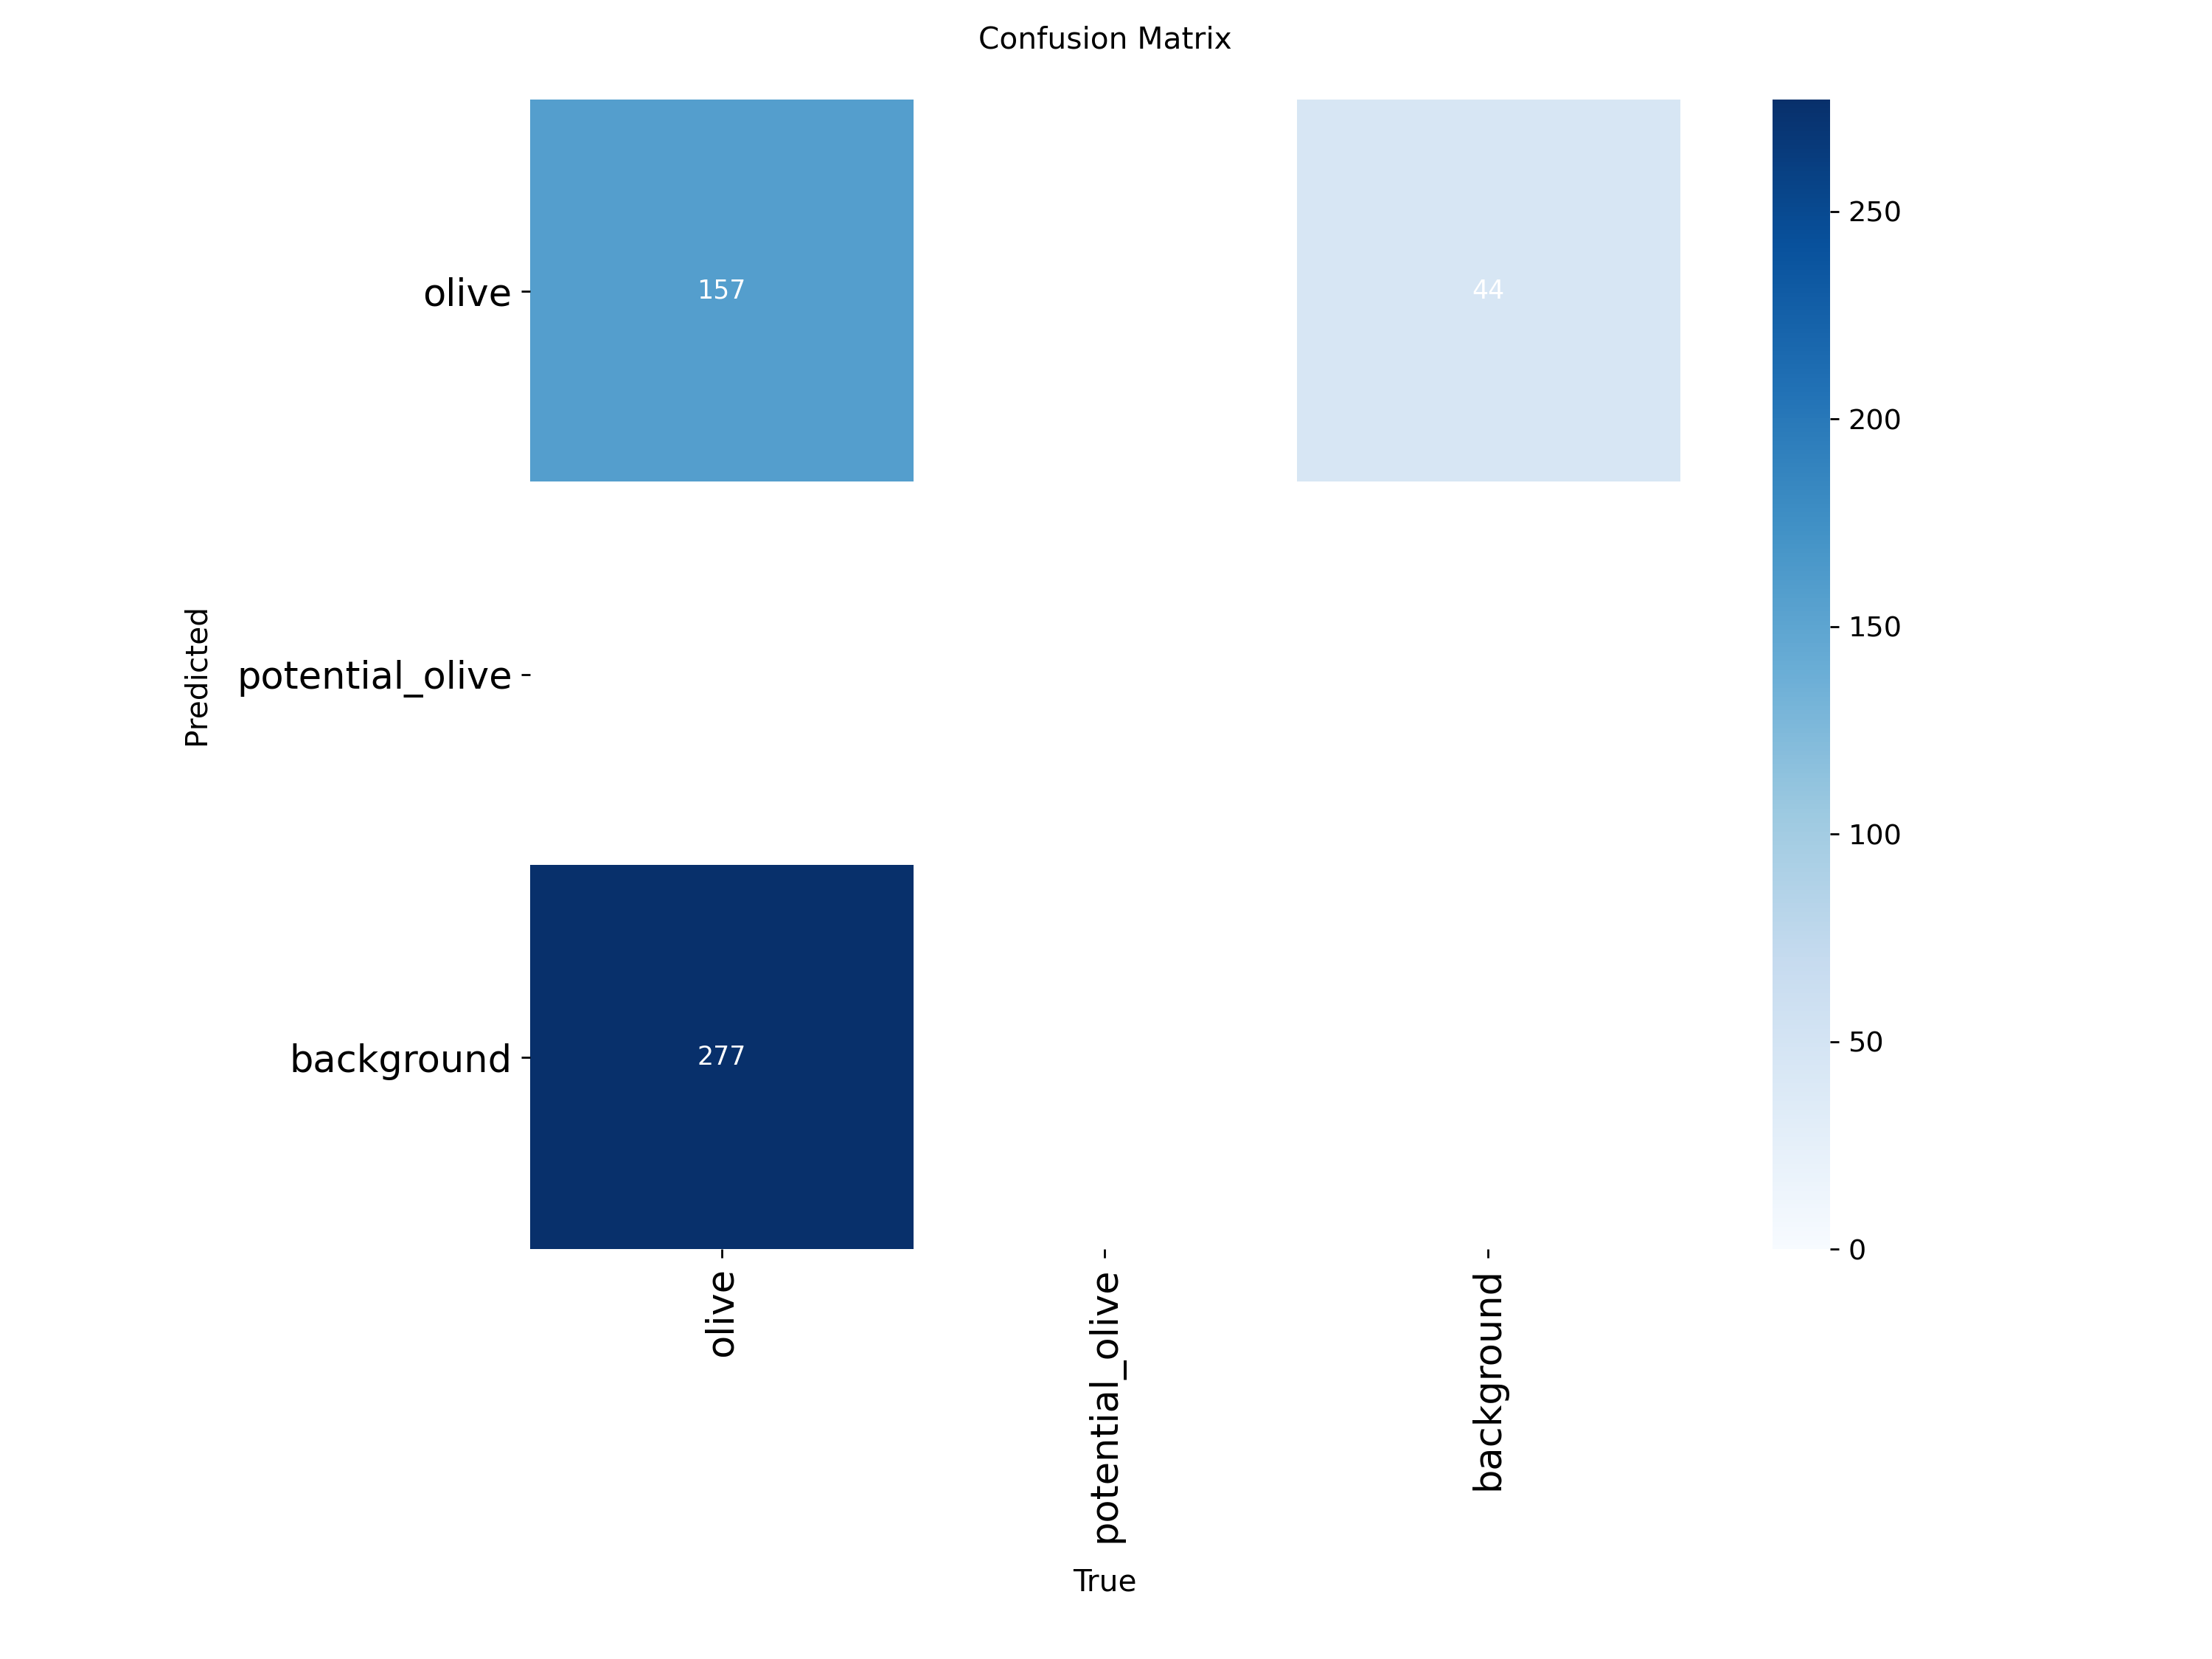

In [20]:
Image(filename='runs/detect/train/confusion_matrix.png', width=600)

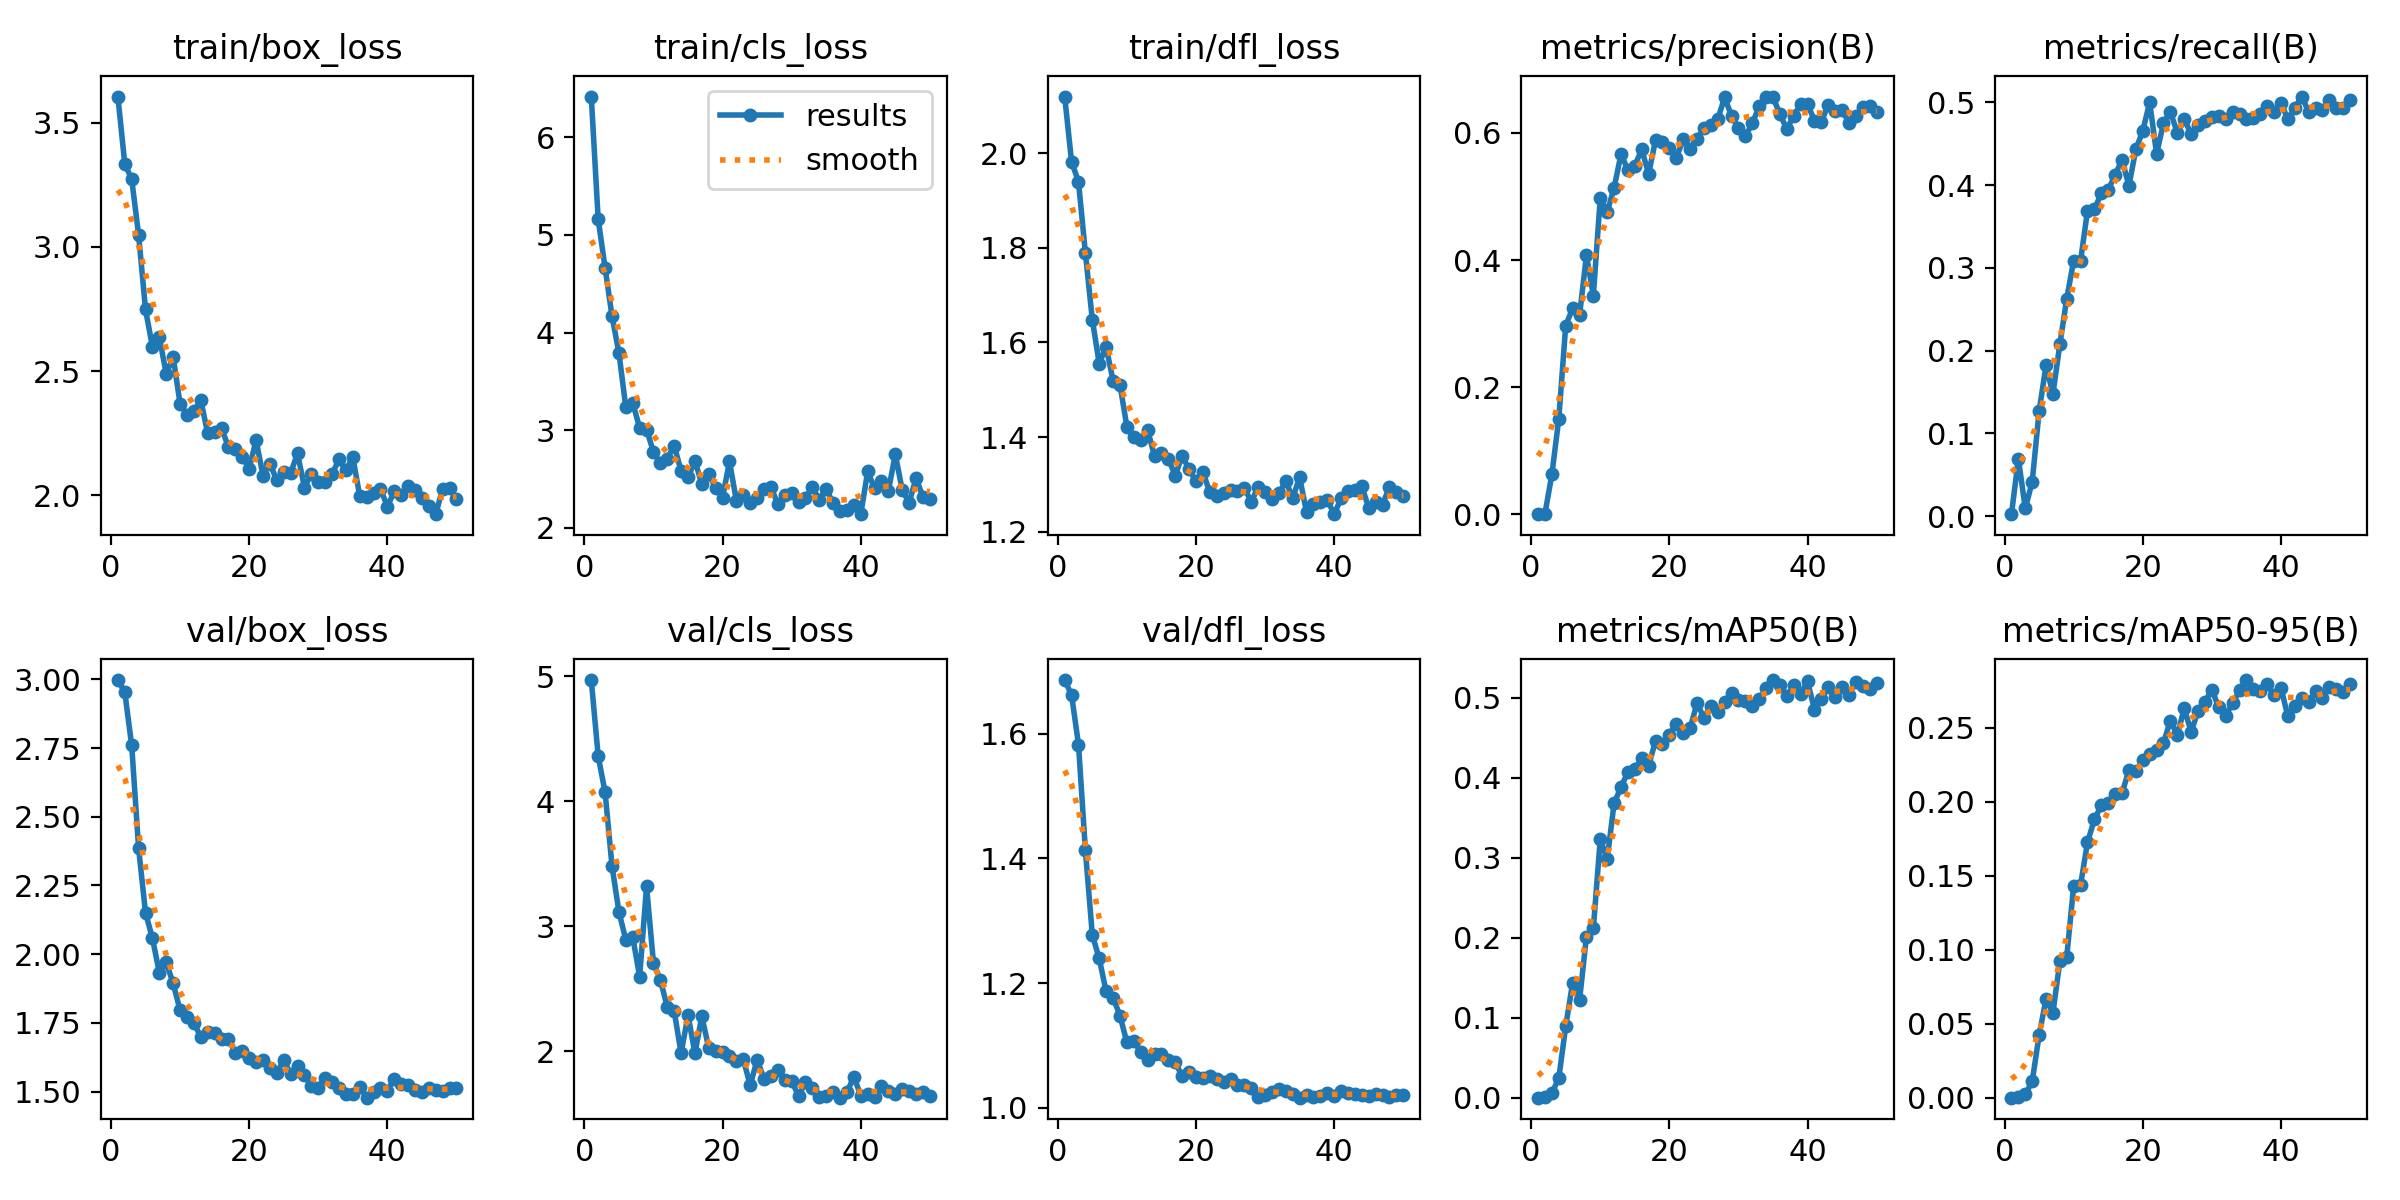

In [21]:
Image(filename='runs/detect/train/results.png', width=600)

# Validation

In [22]:
from ultralytics import YOLO

# Charger le modèle entraîné
model = YOLO("runs/detect/train/weights/best.pt")

# Évaluer sur le dataset de validation
metrics = model.val(data="/content/split_custom_data_hsv/data.yaml", split="val", verbose=False)

# Accès aux métriques par classe
names = model.names  # dict {class_id: name}
precision_per_class = metrics.box.p  # Précision par classe
recall_per_class = metrics.box.r  # Rappel par classe
map50_per_class = metrics.box.ap50  # mAP à IoU de 0.5 par classe
map_per_class = metrics.box.ap  # mAP à IoU de 0.5-0.95 par classe

# Exemple : récupérer les métriques de la classe "olive"
class_name = "olive"
class_id = list(names.values()).index(class_name)

print(f"Métriques pour la classe '{class_name}':")
print(f" - Précision : {precision_per_class[class_id]:.3f}")
print(f" - Rappel    : {recall_per_class[class_id]:.3f}")
print(f" - mAP@50    : {map50_per_class[class_id]:.3f}")
print(f" - mAP@50-95 : {map_per_class[class_id]:.3f}")


Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2388.6±319.0 MB/s, size: 214.1 KB)


val: Scanning /content/split_custom_data_hsv/labels/val.cache... 180 images, 108 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


                   all        180        434      0.661      0.472      0.524      0.285
Speed: 2.4ms preprocess, 70.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val
Métriques pour la classe 'olive':
 - Précision : 0.661
 - Rappel    : 0.472
 - mAP@50    : 0.524
 - mAP@50-95 : 0.285


En modifiant conf

In [26]:
from ultralytics import YOLO
from pathlib import Path
import cv2
import os
from ultralytics.utils.metrics import bbox_iou

# 🔧 Paramètres
model_path = "runs/detect/train/weights/best.pt"
data_path = "/content/split_custom_data_hsv/data.yaml"
val_images_dir = "/content/split_custom_data_hsv/images/val"
conf_threshold = 0.2  # 🔁 MODIFIE ici le seuil de confiance
target_class = "olive"
iou_threshold = 0.5  # pour comptage TP/FN

# 📦 Charger modèle + noms des classes
model = YOLO(model_path)
names = model.names
target_id = list(names.values()).index(target_class)

# 📂 Liste des fichiers image de validation
image_paths = list(Path(val_images_dir).rglob("*.jpg")) + list(Path(val_images_dir).rglob("*.png"))

# 🔢 Compteurs
TP, FP, FN = 0, 0, 0

# 🔍 Parcourir les images
import torch

# 🔍 Parcourir les images
for img_path in image_paths:
    results = model.predict(source=str(img_path), conf=conf_threshold, iou=iou_threshold, verbose=False)[0]

    # Prédictions pour la classe cible
    preds = [b for b in results.boxes.data.cpu().numpy() if int(b[5]) == target_id]
    pred_boxes = [b[:4] for b in preds]  # x1, y1, x2, y2

    # Ground truth : via les annotations val
    label_path = str(img_path).replace("/images/", "/labels/").rsplit(".", 1)[0] + ".txt"
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, w, h = map(float, line.strip().split())
                if int(cls) == target_id:
                    # YOLO format -> (x1, y1, x2, y2)
                    img = cv2.imread(str(img_path))
                    H, W = img.shape[:2]
                    cx, cy, bw, bh = x * W, y * H, w * W, h * H
                    x1 = cx - bw / 2
                    y1 = cy - bh / 2
                    x2 = cx + bw / 2
                    y2 = cy + bh / 2
                    gt_boxes.append([x1, y1, x2, y2])

    # 🧠 Matching GT ↔ prédictions
    matched_gt = set()
    for pred_box in pred_boxes:
        matched = False
        for i, gt_box in enumerate(gt_boxes):
            # Convertir en tensor avant de calculer l'IoU
            pred_box_tensor = torch.tensor(pred_box).unsqueeze(0)  # Convertir en tensor
            gt_box_tensor = torch.tensor(gt_box).unsqueeze(0)  # Convertir en tensor
            iou = bbox_iou(pred_box_tensor, gt_box_tensor)[0]  # Calcul de l'IoU
            if iou > iou_threshold and i not in matched_gt:
                TP += 1
                matched_gt.add(i)
                matched = True
                break
        if not matched:
            FP += 1
    FN += len(gt_boxes) - len(matched_gt)

# 📊 Calcul des métriques
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f"\n🔎 Résultats pour la classe '{target_class}' (seuil conf = {conf_threshold}):")
print(f" - Vrais positifs (TP) : {TP}")
print(f" - Faux positifs (FP)  : {FP}")
print(f" - Faux négatifs (FN)  : {FN}")
print(f" - Précision           : {precision:.3f}")
print(f" - Rappel              : {recall:.3f}")




🔎 Résultats pour la classe 'olive' (seuil conf = 0.2):
 - Vrais positifs (TP) : 181
 - Faux positifs (FP)  : 42
 - Faux négatifs (FN)  : 253
 - Précision           : 0.812
 - Rappel              : 0.417


# Télécharger le modèle

In [27]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

/content/my_model
  adding: my_model.pt (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/confusion_matrix.png (deflated 34%)
  adding: train/val_batch2_labels.jpg (deflated 5%)
  adding: train/train_batch5002.jpg (deflated 6%)
  adding: train/args.yaml (deflated 51%)
  adding: train/results.png (deflated 7%)
  adding: train/F1_curve.png (deflated 18%)
  adding: train/val_batch2_pred.jpg (deflated 5%)
  adding: train/val_batch0_pred.jpg (deflated 7%)
  adding: train/confusion_matrix_normalized.png (deflated 32%)
  adding: train/train_batch2.jpg (deflated 1%)
  adding: train/val_batch1_labels.jpg (deflated 5%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/best.pt (deflated 8%)
  adding: train/weights/last.pt (deflated 8%)
  adding: train/train_batch0.jpg (deflated 5%)
  adding: train/labels_correlogram.jpg (deflated 36%)
  adding: train/R_curve.png (deflated 17%)
  adding: train/val_batch1_pred.jpg (deflated 5%)
  adding: train/train_batch5001.jpg (deflated 5%)
 